In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import ImageCollection
import numpy as np

In [2]:
pwd

'/Users/colettace/projects/general/fluoro_gene_expr/analysis'

# Grab all the videos

In [3]:
import os

In [4]:
input_dir = 'video_data'
output_dir = 'image_data'

In [5]:
input_videos = []
output_name_prefixes = []
for tl_root, tl_dirs, tl_files in os.walk( input_dir ):
    for tl_dir in tl_dirs:
        for root, _dir, files in os.walk( os.path.join( input_dir, tl_dir ) ):
            for f in files:
                # skip single channel, since it can't measure confluence
                if 'singlechannel' in f:
                    continue
                if f.endswith( '.avi' ):
                    video_path = os.path.join( input_dir, tl_dir, f )
                    input_videos.append( video_path )
                    # Grab the date from the directory
                    date = tl_dir.split()[0]
                    # remove spaces from filename
                    new_f = f.replace( ' ', '_' )
                    # remove the .avi form the pathname: slice off the last 4 characters
                    new_f = new_f[:-4]
                    new_name_path = os.path.join( output_dir, date + '_' + new_f )
                    output_name_prefixes.append(new_name_path)

In [6]:
single_channels = [ _ for _ in output_name_prefixes if 'singlechannel' in _ ]
three_channels = [ _ for _ in output_name_prefixes if 'singlechannel' not in _ ]

In [7]:
three_channels

['image_data/20170717_HyperRED_H2O2_500uM_Laser11_1042gain_-8DigO_5speed_10sInter_10mins',
 'image_data/20170717_HyperRED_w_4T1EXO_H2O2_500uM_Laser11_1042gain_-8DigO_5speed_10sInter_10mins',
 'image_data/20170816_HyperRED_4T1exosomes_H2O2_500uM_plate1',
 'image_data/20170816_HyperRED_4T1exosomes_H2O2_500uM_plate2',
 'image_data/20170816_HyperRED_4T1exosomes_H2O2_500uM_plate3',
 'image_data/20170816_HyperRED_H2O2_500uM_plate1',
 'image_data/20170816_HyperRED_H2O2_500uM_plate2',
 'image_data/20170816_HyperRED_H2O2_500uM_plate3',
 'image_data/20170816_WT_RAW_H2O2_500uM']

# Load videos and get summary stats

Remove the 7-pixel border on the left side of all videos

In [8]:
rgb_videos = {}
for frame_prefix in three_channels:
    frames = ImageCollection( frame_prefix + '*.png' )
    rgb_videos[ frame_prefix ] = [ f[:,7:,:] for f in frames ]
    print( frame_prefix, len(frames) )

image_data/20170717_HyperRED_H2O2_500uM_Laser11_1042gain_-8DigO_5speed_10sInter_10mins 60
image_data/20170717_HyperRED_w_4T1EXO_H2O2_500uM_Laser11_1042gain_-8DigO_5speed_10sInter_10mins 60
image_data/20170816_HyperRED_4T1exosomes_H2O2_500uM_plate1 60
image_data/20170816_HyperRED_4T1exosomes_H2O2_500uM_plate2 60
image_data/20170816_HyperRED_4T1exosomes_H2O2_500uM_plate3 60
image_data/20170816_HyperRED_H2O2_500uM_plate1 60
image_data/20170816_HyperRED_H2O2_500uM_plate2 60
image_data/20170816_HyperRED_H2O2_500uM_plate3 60
image_data/20170816_WT_RAW_H2O2_500uM 60


# Mask out images

Empiracally, the bare plastic tends to have the top 18 most common pixel intensities in the RED CHANNEL of the first frame.

In [9]:
from collections import Counter
from skimage.color import gray2rgb, rgb2hsv, hsv2rgb, rgb2gray
from skimage.exposure import equalize_adapthist

In [30]:
def Threshold( grayscale_in, name, _min, _max ):
    """Creates a threshold figure"""
    print(name, _min, _max )
    three_chan_gray = equalize_adapthist( gray2rgb( grayscale_in ) )
    hsv = rgb2hsv( three_chan_gray )
    plastic_mask = (grayscale_in >= _min) & (grayscale_in <= _max)
    # Turn on color saturation level
    hsv[:,:,1] = 0.7
    # make the color red (hue = 0)
    hsv[:,:,0][ plastic_mask ] = 0
    # make everything else green (hue = 1/3)
    hsv[:,:,0][ ~plastic_mask ] = 0.333333
    out = np.hstack( ( three_chan_gray, np.fliplr( hsv2rgb( hsv ) ) ) )
    #out = np.hstack( ( three_chan_gray, hsv2rgb( hsv) ) )
    
    confluence = (~plastic_mask).sum() / grayscale_in.size
    fig, ax = plt.subplots( figsize=(10,5), dpi=200)
    ax.imshow( out )
    ax.set_title( name + '\nConfluence={:0.1f}%, bare plastic px threshold: {} <= x <= {}'.format(
                            confluence * 100, _min, _max) )
    fig.savefig( name + "_threshold.pdf" )
    return confluence

In [28]:
def IlluminationCorrection( grayscale_in, tol=1.0, maxC=0.2 ):
    
    nrows, ncols = grayscale_in.shape
    biggest_dim = max([nrows,ncols])
    # ==============================================
    def GenerateScalingMatrix( C ):
        scale_matr = np.empty( grayscale_in.shape )
        for y in range( nrows ):
            for x in range( ncols ):
                scale_matr[x,y] = ( (x-y)/ biggest_dim ) * C
        scale_matr += np.ones( frame0_R.shape )
        #plt.imshow( correction )
        #plt.colorbar()
        return scale_matr
    # ==============================================
    
    frmt_str = "Iteration {}: C={}, bot_left_mean={:0.2f}, top_right_mean={:0.2f}, diff={:0.2f}"
    candidate = grayscale_in.copy()
    C = 0.0
    i = 0
    while True:
        bot_left = candidate[-100:,:100]
        top_right = candidate[:100,-100:]
        bot_left_mean = bot_left.mean()
        top_right_mean = top_right.mean()
        print( frmt_str.format( i, C, bot_left_mean, top_right_mean, abs( bot_left_mean - top_right_mean ) ) )
        if abs( bot_left_mean - top_right_mean ) < tol:
            break
        if abs(C) > maxC:
            # 20% correction doesn't work? bail
            raise ValueError( "Correction didnt work" )
        C -= 0.001
        i += 1
        scaling_matr = GenerateScalingMatrix( C )
        candidate = (scaling_matr * candidate).round().astype(np.uint8)
    
    return candidate

Iteration 0: C=0.0, bot_left_mean=85.48, top_right_mean=71.32, diff=14.16
Iteration 1: C=-0.001, bot_left_mean=85.48, top_right_mean=71.32, diff=14.16
Iteration 2: C=-0.002, bot_left_mean=85.48, top_right_mean=71.32, diff=14.16
Iteration 3: C=-0.003, bot_left_mean=85.48, top_right_mean=71.32, diff=14.16
Iteration 4: C=-0.004, bot_left_mean=85.48, top_right_mean=71.32, diff=14.16
Iteration 5: C=-0.005, bot_left_mean=85.48, top_right_mean=71.32, diff=14.15
Iteration 6: C=-0.006, bot_left_mean=85.44, top_right_mean=71.32, diff=14.12
Iteration 7: C=-0.007, bot_left_mean=85.08, top_right_mean=71.33, diff=13.75
Iteration 8: C=-0.008, bot_left_mean=84.30, top_right_mean=71.50, diff=12.80
Iteration 9: C=-0.009000000000000001, bot_left_mean=83.34, top_right_mean=72.11, diff=11.23
Iteration 10: C=-0.010000000000000002, bot_left_mean=82.34, top_right_mean=73.02, diff=9.32
Iteration 11: C=-0.011000000000000003, bot_left_mean=81.34, top_right_mean=74.02, diff=7.32
Iteration 12: C=-0.012000000000000

/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Iteration 0: C=0.0, bot_left_mean=84.73, top_right_mean=70.80, diff=13.93
Iteration 1: C=-0.001, bot_left_mean=84.73, top_right_mean=70.80, diff=13.93
Iteration 2: C=-0.002, bot_left_mean=84.73, top_right_mean=70.80, diff=13.93
Iteration 3: C=-0.003, bot_left_mean=84.73, top_right_mean=70.80, diff=13.93
Iteration 4: C=-0.004, bot_left_mean=84.73, top_right_mean=70.80, diff=13.93
Iteration 5: C=-0.005, bot_left_mean=84.73, top_right_mean=70.80, diff=13.93
Iteration 6: C=-0.006, bot_left_mean=84.71, top_right_mean=70.80, diff=13.91
Iteration 7: C=-0.007, bot_left_mean=84.38, top_right_mean=70.81, diff=13.58
Iteration 8: C=-0.008, bot_left_mean=83.62, top_right_mean=70.95, diff=12.67
Iteration 9: C=-0.009000000000000001, bot_left_mean=82.66, top_right_mean=71.56, diff=11.10
Iteration 10: C=-0.010000000000000002, bot_left_mean=81.66, top_right_mean=72.46, diff=9.20
Iteration 11: C=-0.011000000000000003, bot_left_mean=80.66, top_right_mean=73.46, diff=7.20
Iteration 12: C=-0.012000000000000

Iteration 16: C=-0.016000000000000007, bot_left_mean=79.13, top_right_mean=79.90, diff=0.77
image_data/20170816_HyperRED_H2O2_500uM_plate2 78 83
Iteration 0: C=0.0, bot_left_mean=87.14, top_right_mean=73.13, diff=14.01
Iteration 1: C=-0.001, bot_left_mean=87.14, top_right_mean=73.13, diff=14.01
Iteration 2: C=-0.002, bot_left_mean=87.14, top_right_mean=73.13, diff=14.01
Iteration 3: C=-0.003, bot_left_mean=87.14, top_right_mean=73.13, diff=14.01
Iteration 4: C=-0.004, bot_left_mean=87.14, top_right_mean=73.13, diff=14.01
Iteration 5: C=-0.005, bot_left_mean=87.13, top_right_mean=73.13, diff=14.01
Iteration 6: C=-0.006, bot_left_mean=87.06, top_right_mean=73.13, diff=13.93
Iteration 7: C=-0.007, bot_left_mean=86.65, top_right_mean=73.16, diff=13.50
Iteration 8: C=-0.008, bot_left_mean=85.86, top_right_mean=73.36, diff=12.49
Iteration 9: C=-0.009000000000000001, bot_left_mean=84.88, top_right_mean=74.08, diff=10.80
Iteration 10: C=-0.010000000000000002, bot_left_mean=83.88, top_right_mea

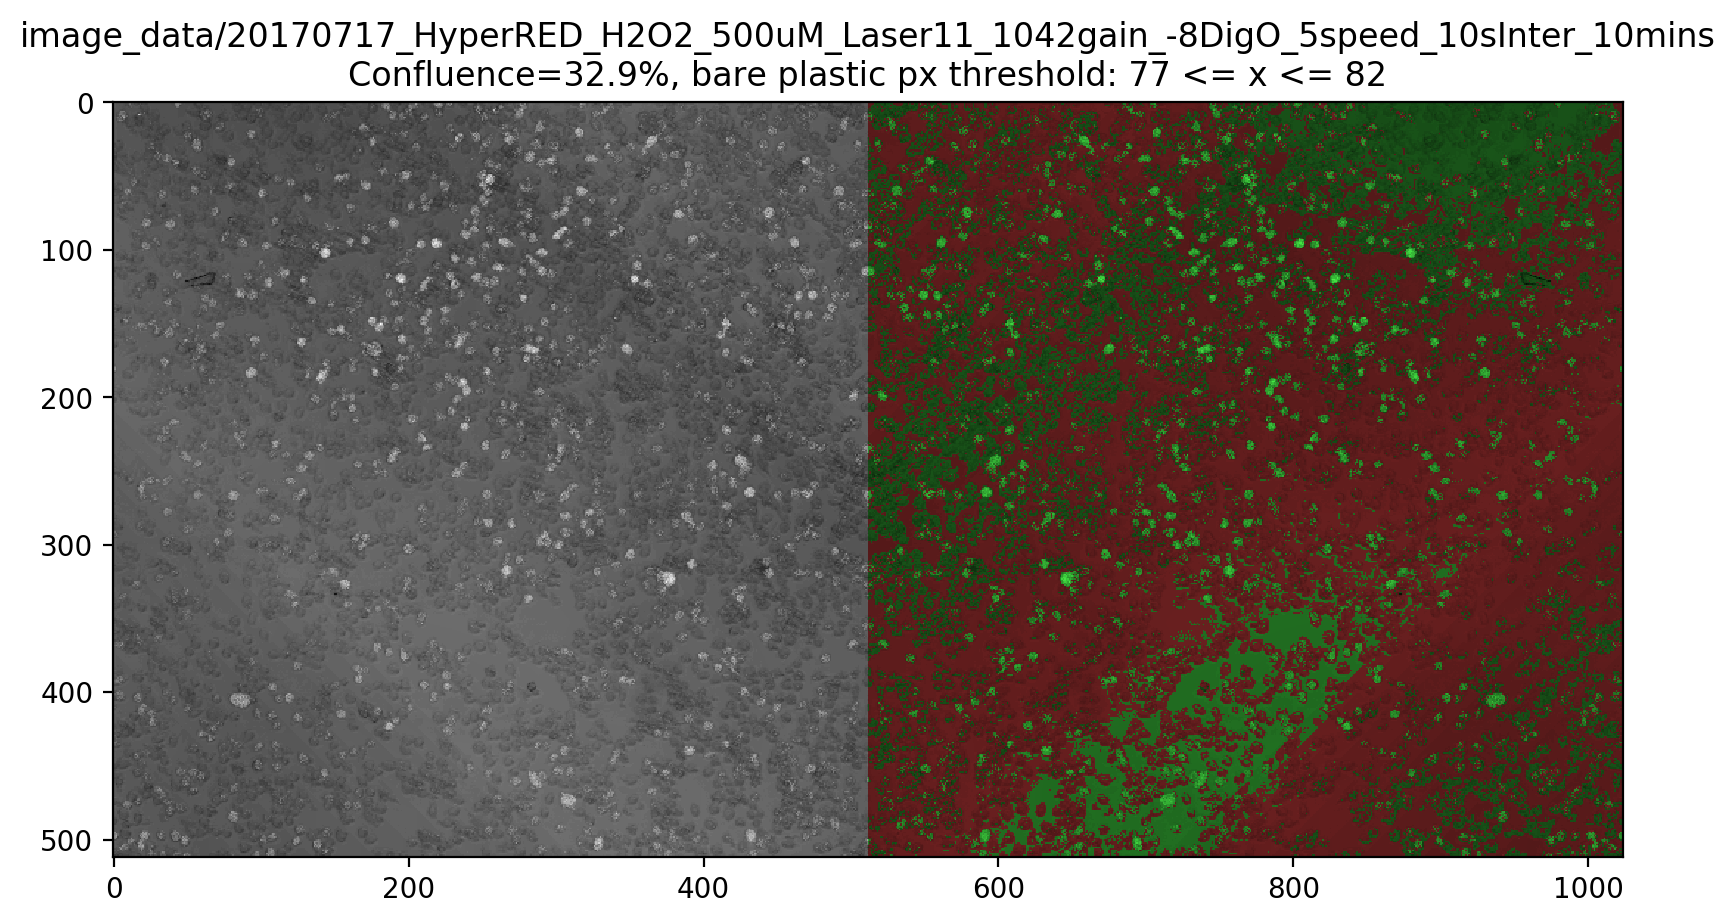

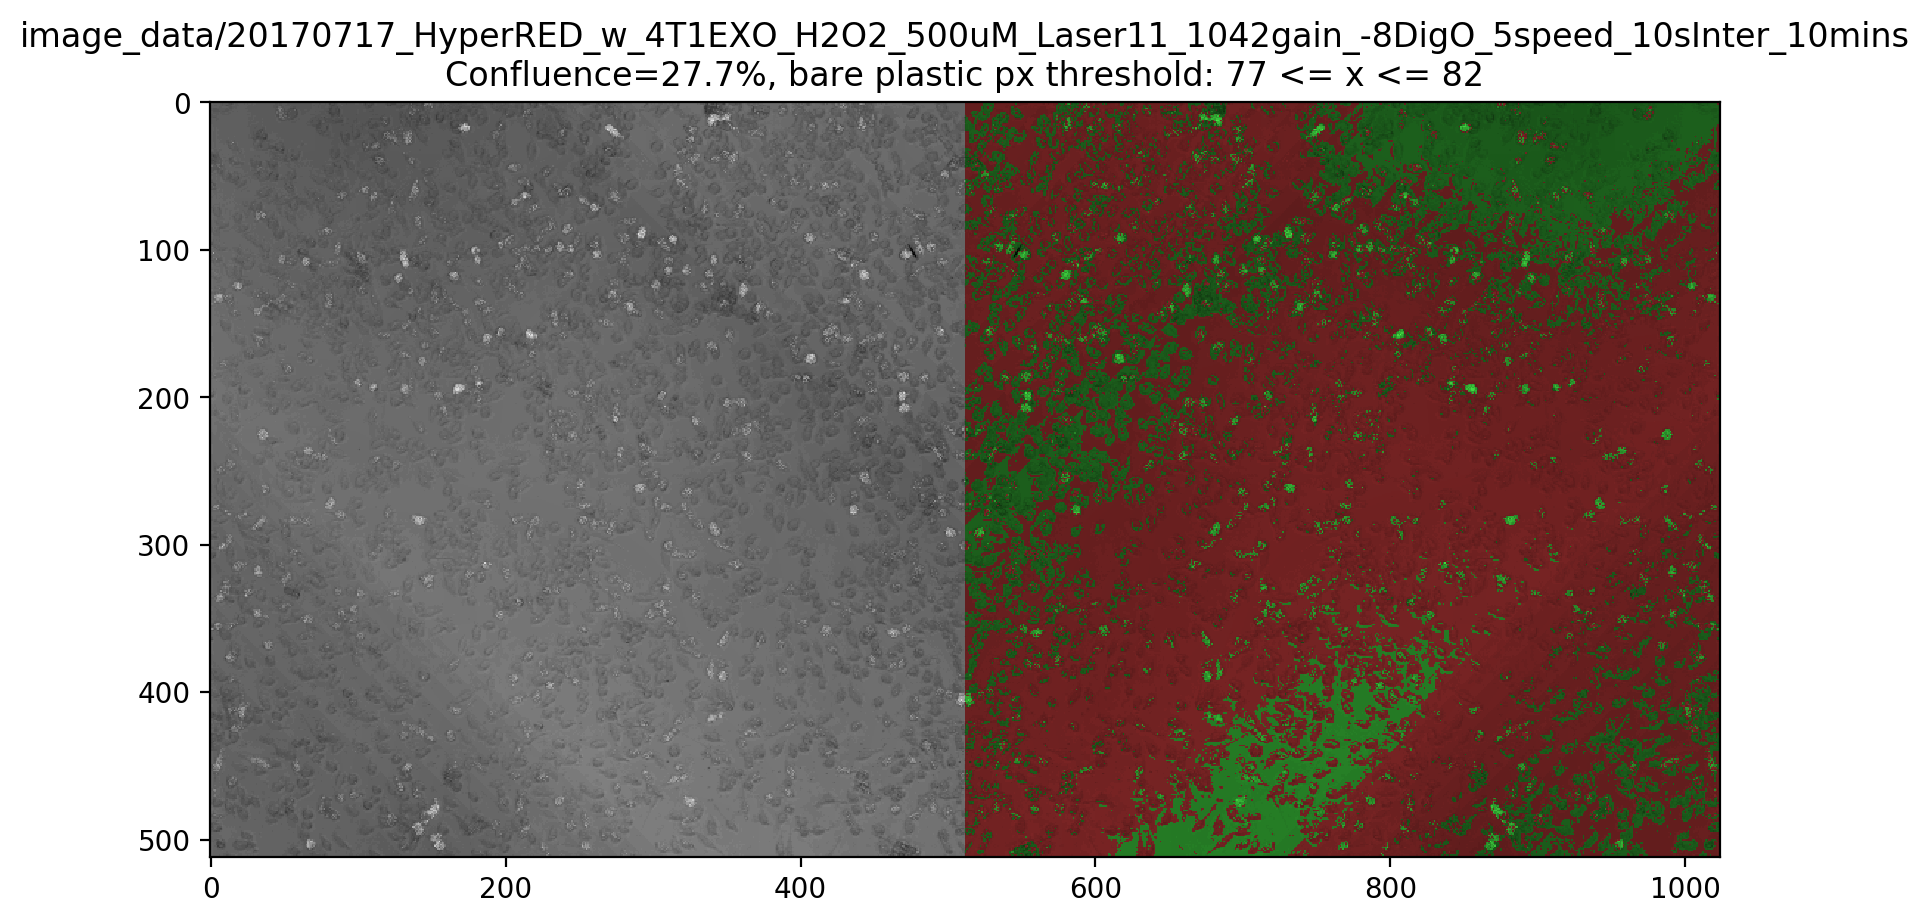

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


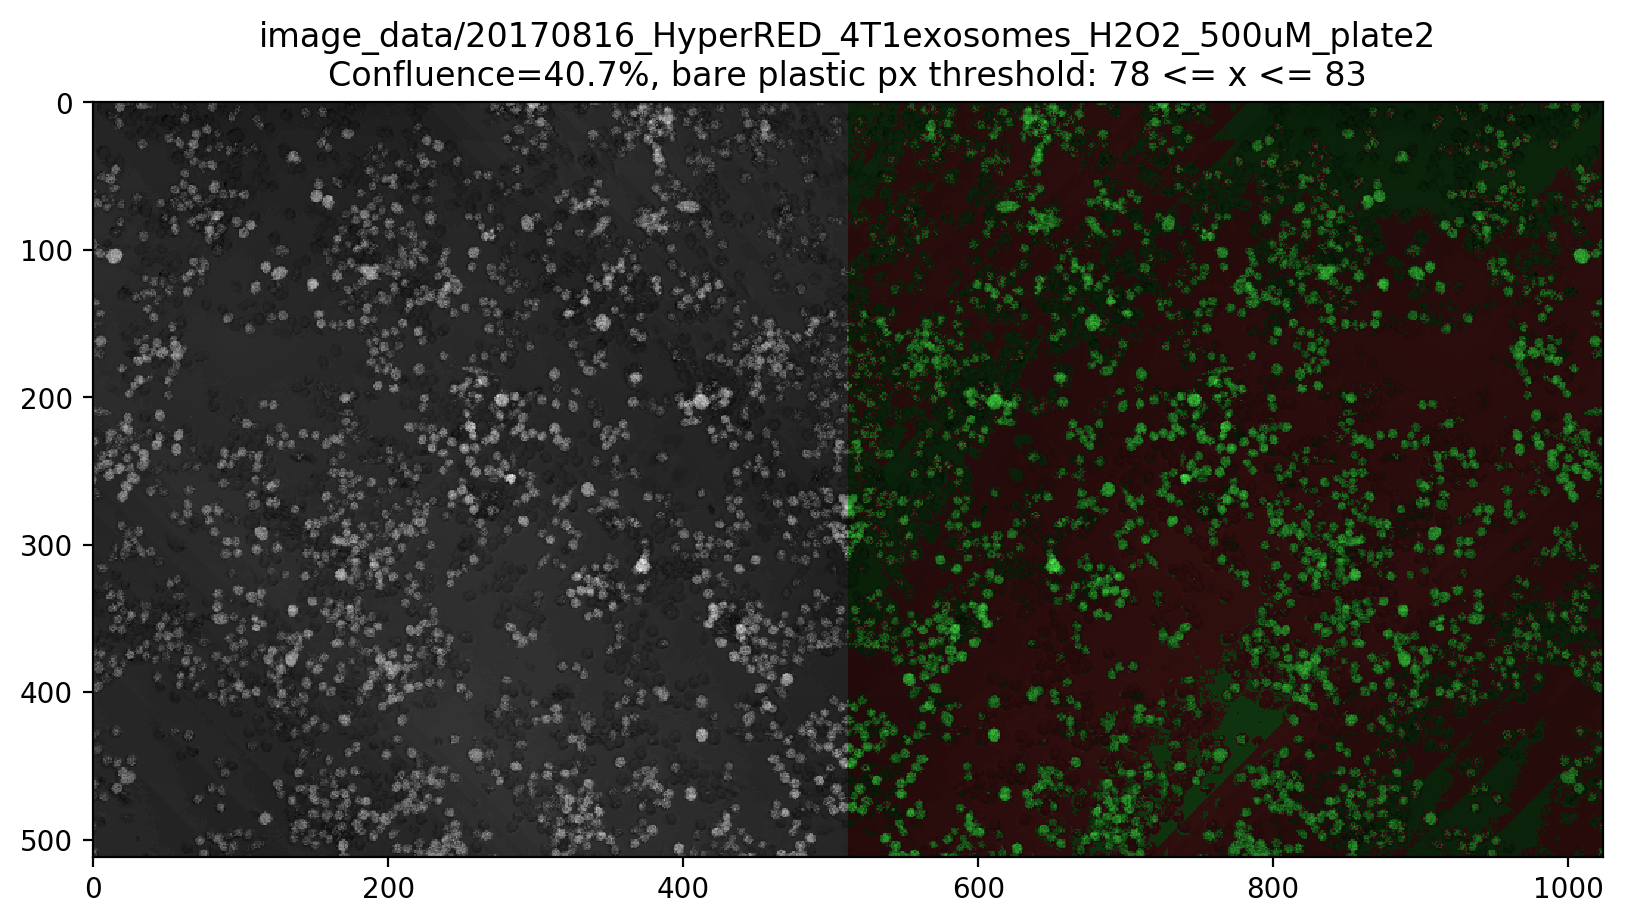

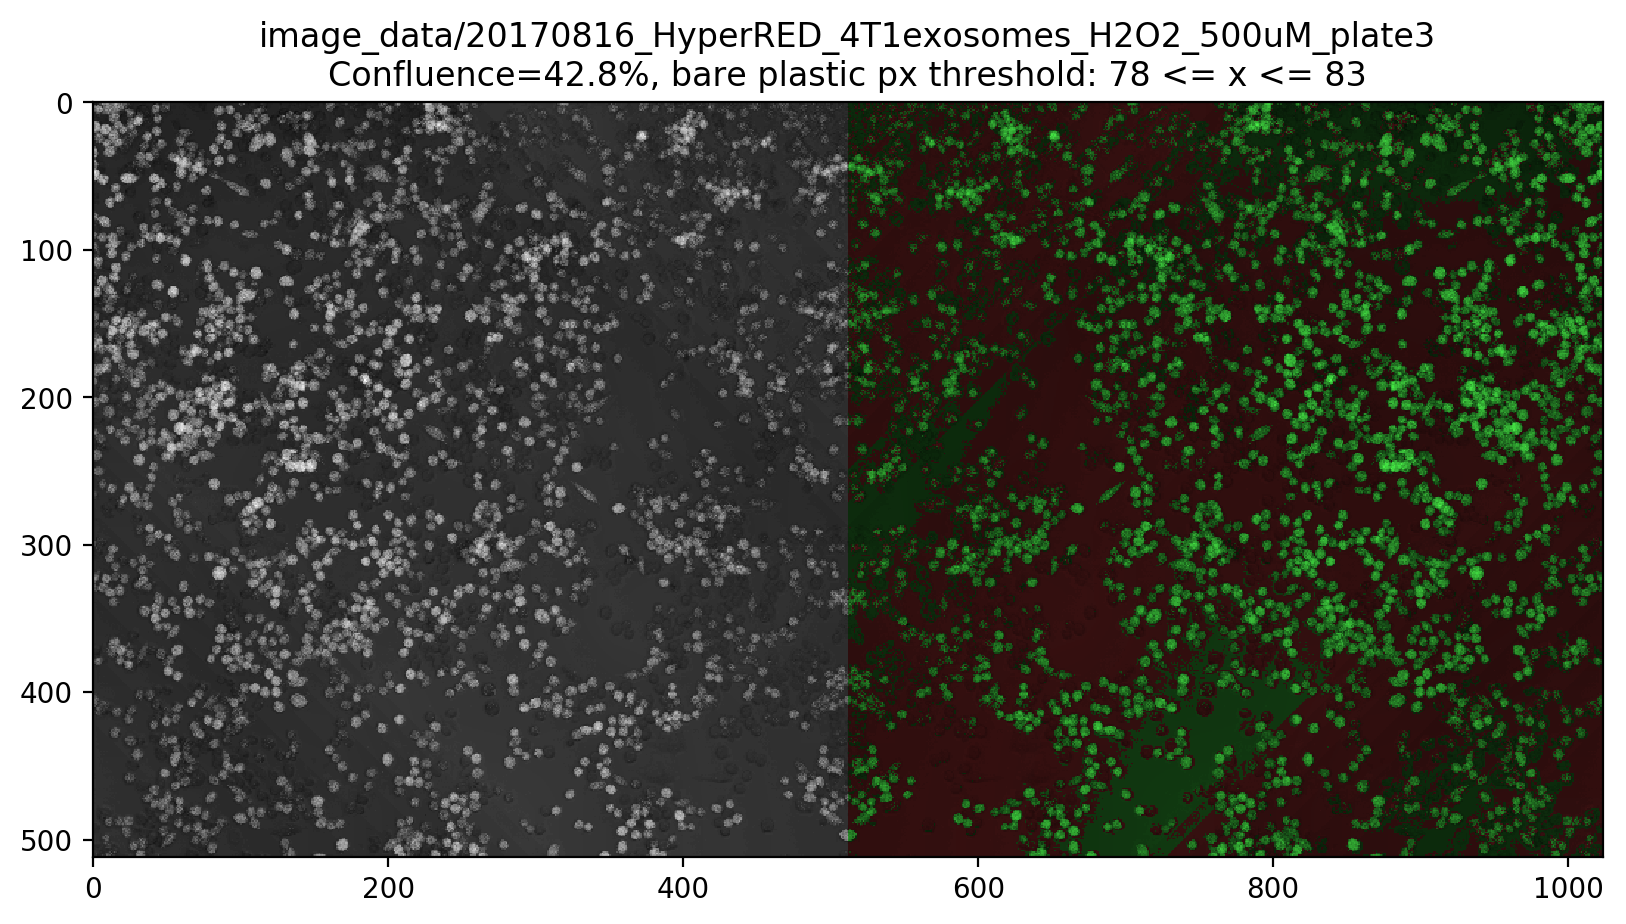

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


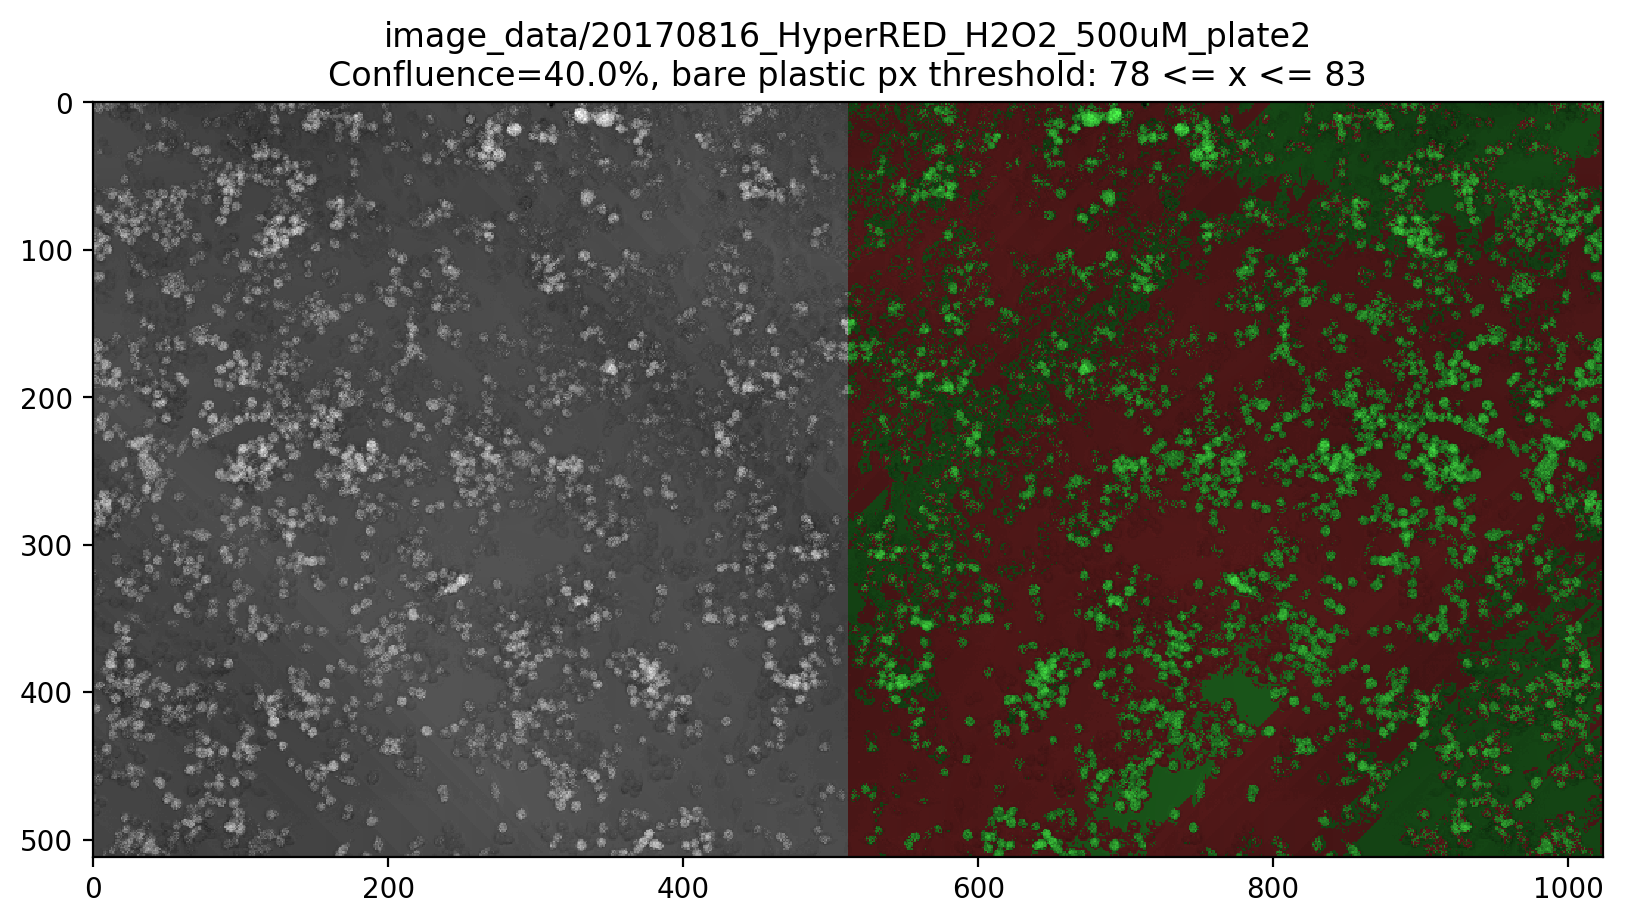

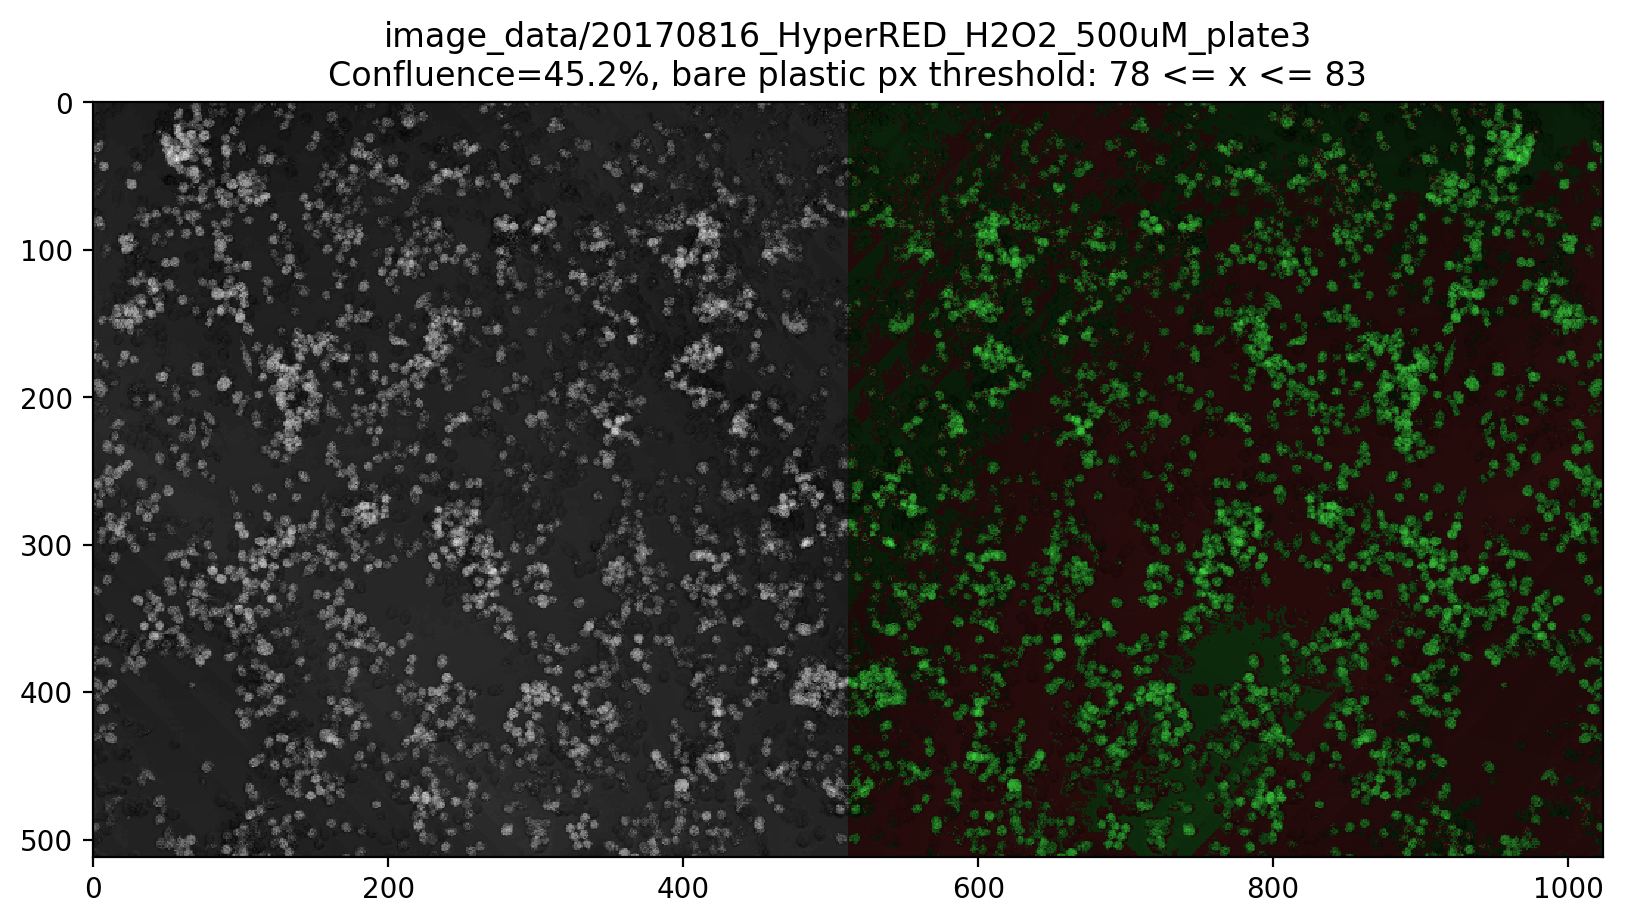

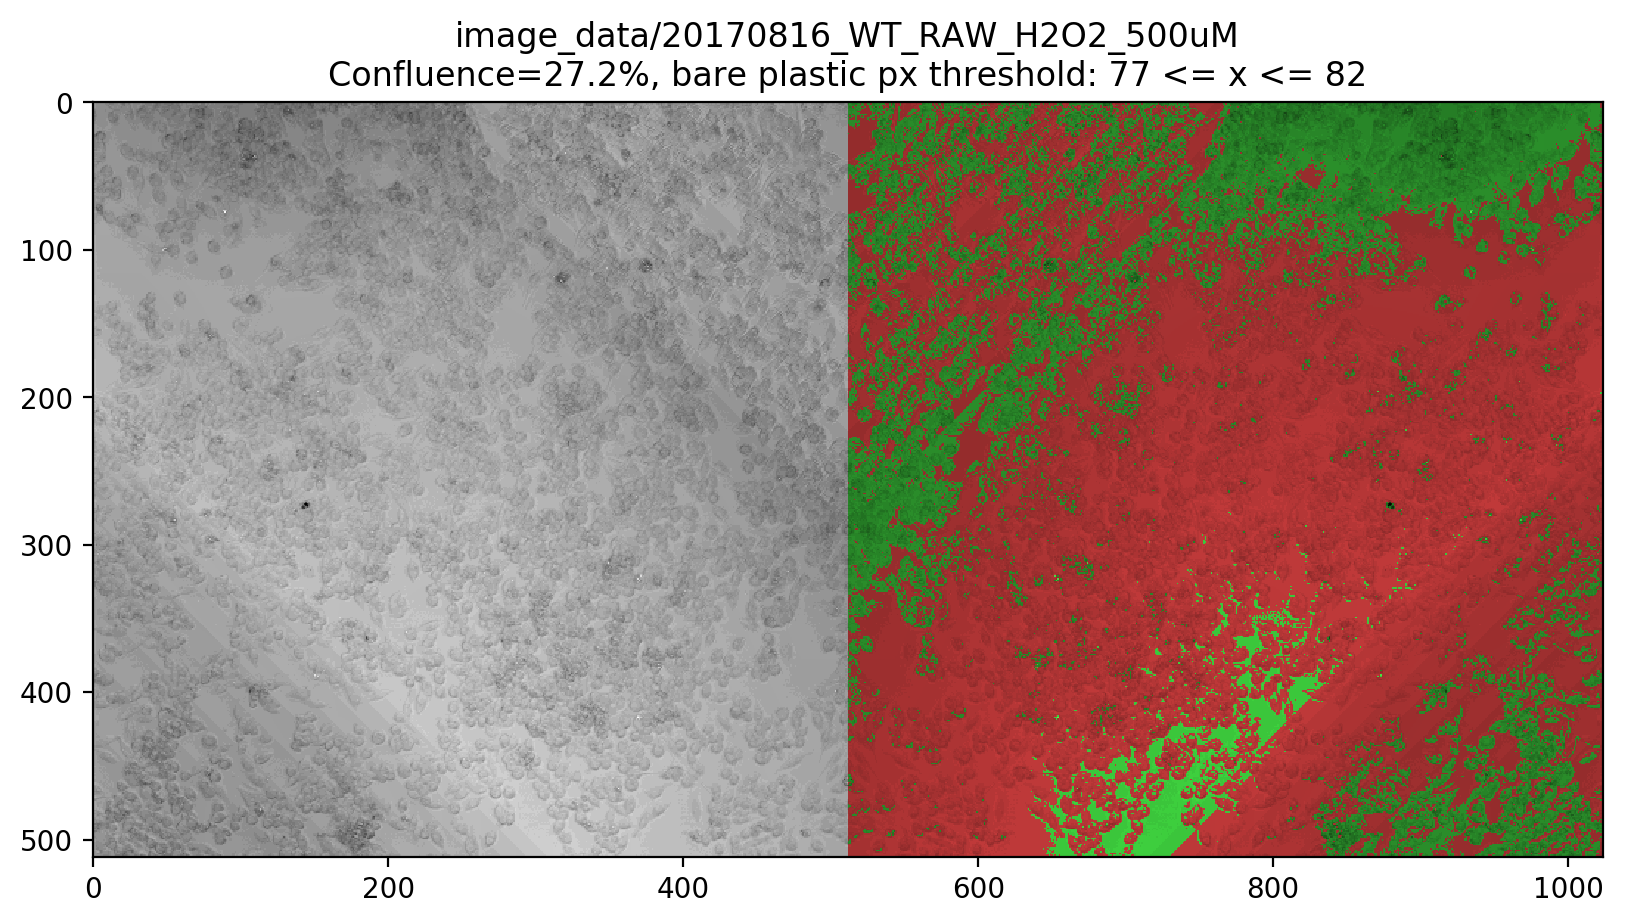

In [31]:
n_throwout_vals = 6
threshold_correction = 1
confluences = []
for name, vid in rgb_videos.items():
    frame0_R = vid[0][:,:,0].copy()
    corrected = IlluminationCorrection( frame0_R )
    vals = [_[0] for i, _ in enumerate( Counter(corrected.flatten()).most_common()) if i < n_throwout_vals ]
    vals = [ _ + threshold_correction for _ in vals ]
    _min = min( vals )
    _max = max(vals)
    confluence = Threshold( corrected, name, _min, _max )
    confluences.append( ( confluence, name ) ) 
